In [219]:
import numpy as np
import pandas as pd
from collections import defaultdict
import time
from datetime import datetime
import sys
import math
import seaborn as sns
import matplotlib.pyplot as plt
if 'holidays' not in sys.modules:
    !pip install holidays
import holidays

In [223]:
driver_df = pd.read_csv('driver_ids.csv', parse_dates = ['driver_onboard_date'])
ride_df = pd.read_csv('ride_ids.csv')
ride_timestamps_df = pd.read_csv('ride_timestamps.csv', parse_dates = ['timestamp'])

'''
rides info combined dataframe
'''
big_rides_info = pd.read_csv('added_variables_rides_info.csv', parse_dates = ['driver_onboard_date', 'requested_at','accepted_at',
                                                                             'arrived_at','picked_up_at','dropped_off_at'])
print(big_rides_info.shape)
display(big_rides_info.head())

'''
drivers info combined dataframe
'''
big_drivers_info = pd.read_csv('temp_added_drivers_info.csv', parse_dates = ['driver_onboard_date', 'last_ride']).set_index('driver_id')
print(big_drivers_info.shape)
display(big_drivers_info.head())

'''
driving intervals
'''
percentile = pd.read_csv('driving_interval.csv').set_index('driver_id')
print(percentile.shape)
display(percentile.head())

big_rides_info = big_rides_info.set_index('driver_id')
import datetime
big_rides_info['first_week_milestone'] = big_rides_info['driver_onboard_date'] + datetime.timedelta(days=7)
big_rides_info['day']= big_rides_info.groupby('driver_id').requested_at.apply(lambda x: x.apply(lambda x: x.date()))

big_rides_info['first_week_milestone'] = big_rides_info['first_week_milestone'].apply(lambda x: x.date())
big_rides_info['number of days onboard'] = (big_rides_info['day']- big_rides_info['driver_onboard_date'].apply(lambda x:x.date())).apply(lambda x: x.days+1)


(184209, 18)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,speed(m/s),holiday,weekend,time of day,season,time spent to arrive at the customer(minutes),fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,5.538226,0,1,4,0,2.766667,9.360365
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,4.155748,0,0,3,0,3.133333,9.113439
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,5.737762,0,0,1,1,5.016667,8.187399
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,19.557519,0,0,1,0,2.850000,78.170140
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,5.000000,0,0,3,0,1.550000,19.403323


(837, 22)


,prime time rides percentage,average daily active time(hrs/day),gross fare(over all rides),average daily fare,average fare per ride,average monthly fare,total rides,number of abnormal rides,completion rate,active days,...,driver_onboard_date,total days with Lyft,Retention Rate,Lifetime Value,Lifetime,Work_Period,Value,Average Speed,Average Single Ride Duration,Average Single Ride Distance
driver_id,,,,,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.397112,1.097411,3651.957780,65.213532,13.183963,912.989445,277,0,1.0,56,...,2016-03-29,90,0.622222,4756.038040,2.093023,Day,Medium,6.690127,798.693141,6282.624549
007f0389f9c7b03ef97098422f902e62,0.387097,0.474468,332.355469,27.696289,10.721144,83.088867,31,0,1.0,12,...,2016-03-29,90,0.133333,45.842134,1.034483,Day,Low,5.706670,661.193548,3791.322581
011e5c5dfc5c2c92501b8b24d47509bc,0.470588,0.676042,493.765123,41.147094,14.522504,164.588374,34,0,1.0,12,...,2016-04-05,83,0.144578,74.718556,1.046658,Day,Low,7.013431,858.970588,7930.970588
0152a2f305e71d26cc964f8d4411add9,0.251309,1.211951,2644.233047,66.105826,13.844152,881.411016,191,0,1.0,40,...,2016-04-23,65,0.615385,3357.756250,2.063492,Night,Medium,7.735094,913.722513,7702.821990
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,5457.997548,136.449939,14.554660,1819.332516,375,0,1.0,40,...,2016-04-29,59,0.677966,8767.867546,2.369478,Day,High,7.498338,953.181333,8329.717333


(837, 20)


,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,75%,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
driver_id,,,,,,,,,,,,,,,,,,,,
7ff85c5c0e9324e28d1e0d0589c364bd,15.033426,0.323981,14.740000,14.751958,14.763917,14.787833,14.799792,14.859583,14.979167,15.180139,15.280625,15.300722,15.340917,15.361014,15.381111,0.609056,0.577000,0.512889,0.480833,0.320556
7b625f643d0775f0ac4898e33235377b,18.056574,1.258248,16.604722,16.711222,16.817722,17.030722,17.137222,17.669722,18.734722,18.782500,18.806389,18.811167,18.820722,18.825500,18.830278,2.114278,2.003000,1.780444,1.669167,1.112778
0822973f3e812a68a867962dbbd37f5d,23.756682,0.795498,22.552500,22.623472,22.652153,22.786667,22.879965,23.193611,23.771111,24.248194,24.669549,24.736389,24.840000,25.024167,26.208333,2.400694,2.187847,1.949722,1.789583,1.054583
80cb80668a3c444e3e8962d1c861b9d0,21.527642,0.669526,19.926944,20.026986,20.195333,20.661833,20.766875,21.226528,21.510556,21.869722,22.195347,22.356667,22.467833,22.657903,23.109722,2.630917,2.272500,1.694833,1.428472,0.643194
1805f90c5220ac830835df3309a76e78,18.330698,1.364033,12.123611,16.851111,17.470611,17.509500,17.590417,17.946111,18.290556,18.683056,19.616111,20.022333,20.362944,20.635333,20.760833,3.784222,2.892333,2.512833,2.025694,0.736944


In [44]:
def plot_event(df1, df2, title):
    sns.set_style('white')
    fig = plt.figure(figsize = (15,8))
    ax = sns.distplot([((t.hour * 60 + t.minute) * 60 + t.second)//1800 for t in df1['time']], bins = np.arange(0,48), label = 'Baseline', hist=True, kde=False, color = sns.xkcd_rgb['golden rod'])
    sns.distplot([((t.hour * 60 + t.minute) * 60 + t.second)//1800 for t in df2['time']], bins = np.arange(0,48), label = '3 months', hist=True, kde=False, color = sns.xkcd_rgb['nice blue'])
    #ax.set_xticks(np.arange(0,24))
    #ax.set_xticks(np.arange(0,48))
    plt.xticks(np.arange(0, 48), pd.Series(np.arange(0,48)).apply(lambda x: str(x//2) if x % 6 == 0 else ''), fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.legend(labels=['Baseline','3 months'], fontsize = 16,framealpha = 1, facecolor = 'white')
    #ax.set_xticklabels(pd.Series(np.arange(48)).apply(lambda x: '0'+ str(x)+ ':00'))
    #ax.set_xticklabels(pd.Series(np.arange(48)).apply(lambda x: '0'+ str(x//2)+ ':' + str(x%2*3) +'0' if len(str(x//2))==1 else str(x//2)+ ':' + str(x%2*3) +'0'),rotation=45)

    if title == 'TRE':
        plt.axvline(x=18, color='k', linestyle='--')
        plt.axvline(x=38, color='k', linestyle='--')
    title = title + ' Caffeinated Items Consumption'
    plt.title(title, fontsize = 16)
    plt.xlabel('Hour of Day', fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    return fig

In [224]:
active_rate = big_rides_info.reset_index().groupby('number of days onboard').driver_id.nunique()/big_rides_info.index.nunique()

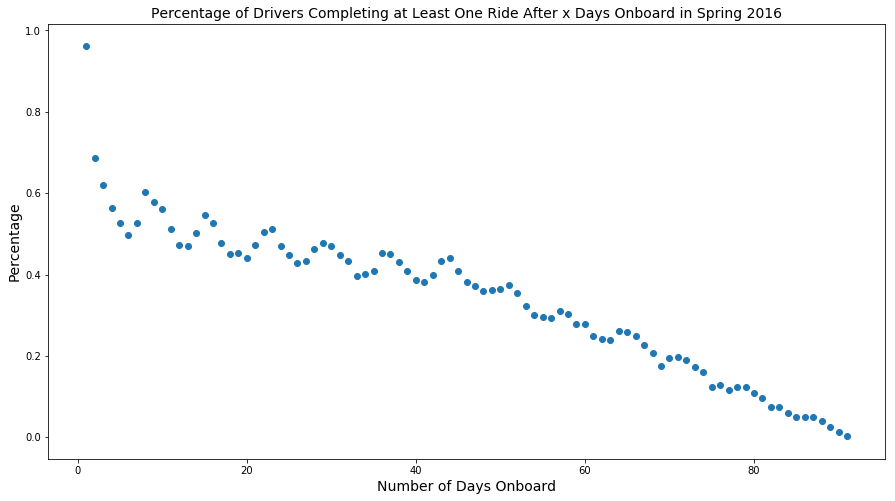

In [225]:
fig = plt.figure(figsize = (15,8))
plt.scatter(active_rate.index,active_rate)
plt.title('Percentage of Drivers Completing at Least One Ride After x Days Onboard in Spring 2016', fontsize = 14)
plt.xlabel('Number of Days Onboard', fontsize = 14)
plt.ylabel('Percentage', fontsize = 14)
plt.savefig('Macro_percent.jpg')

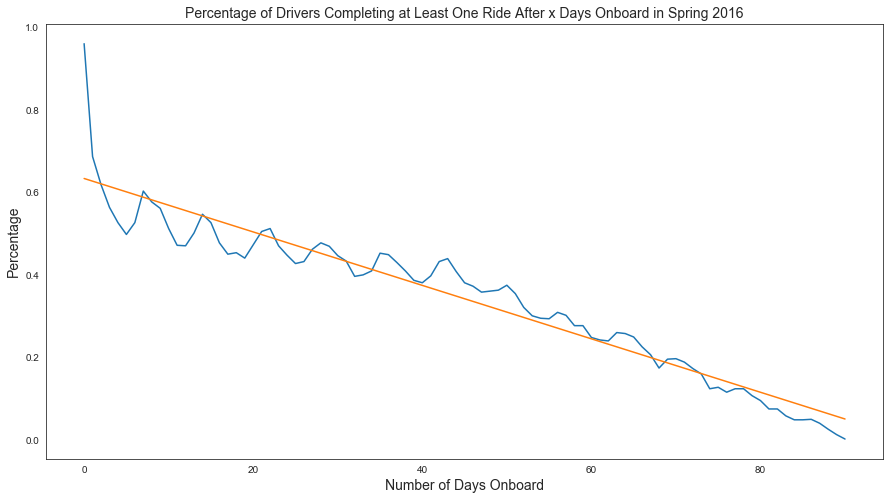

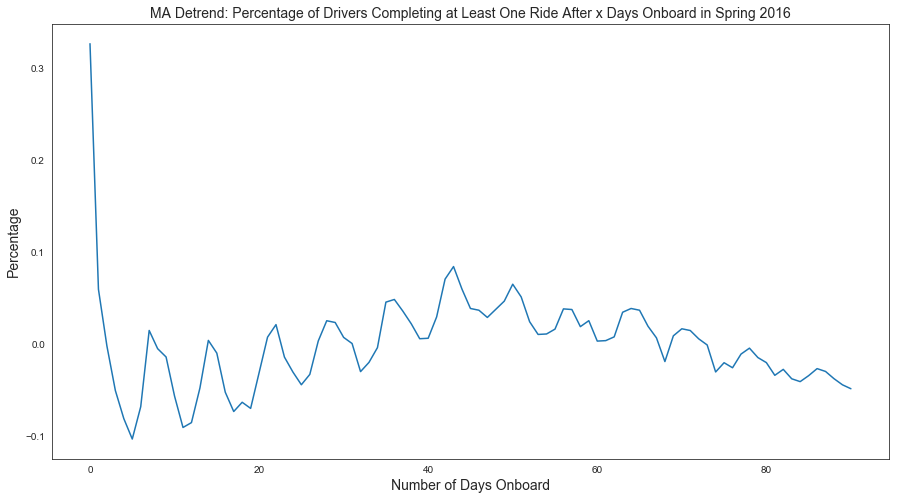

In [378]:
# fit linear model
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(active_rate))]
X = np.reshape(X, (len(X), 1))
y = active_rate.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
fig = plt.figure(figsize = (15,8))
plt.plot(y)
plt.plot(trend)

#plt.scatter(active_rate.index,active_rate)
plt.title('Percentage of Drivers Completing at Least One Ride After x Days Onboard in Spring 2016', fontsize = 14)
plt.xlabel('Number of Days Onboard', fontsize = 14)
plt.ylabel('Percentage', fontsize = 14)
plt.savefig('Macro_percent.jpg', dpi = 300)

plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(active_rate))]
# plot detrended
fig = plt.figure(figsize = (15,8))

plt.plot(detrended)
plt.title('MA Detrend: Percentage of Drivers Completing at Least One Ride After x Days Onboard in Spring 2016', fontsize = 14)
plt.xlabel('Number of Days Onboard', fontsize = 14)
plt.ylabel('Percentage', fontsize = 14)
plt.savefig('Macro_percent_detrended.jpg', dpi = 300)


In [227]:
for anid in big_rides_info.index.unique():
    df = big_rides_info.loc[anid]
    display(df)
    plt.line(df['day'],df['ride_duration'])
    break

,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,speed(m/s),holiday,weekend,time of day,season,time spent to arrive at the customer(minutes),fare,first_week_milestone,day,number of days onboard
driver_id,,,,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,5.538226,0,1,4,0,2.766667,9.360365,2016-04-05,2016-04-23,26
002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,4.155748,0,0,3,0,3.133333,9.113439,2016-04-05,2016-03-29,1
002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,5.737762,0,0,1,1,5.016667,8.187399,2016-04-05,2016-06-21,85
002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,19.557519,0,0,1,0,2.850000,78.170140,2016-04-05,2016-05-19,52
002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,5.000000,0,0,3,0,1.550000,19.403323,2016-04-05,2016-04-20,23
002be0ffdc997bd5c50703158b7c2491,03d6b9d80b8a96135cb9b25178e9e203,4832,917,100,2016-03-29,2016-06-21 08:29:17,2016-06-21 08:29:24,2016-06-21 08:35:33,2016-06-21 08:35:36,2016-06-21 08:50:53,5.269357,0,0,0,1,6.266667,21.115099,2016-04-05,2016-06-21,85
002be0ffdc997bd5c50703158b7c2491,04053c0ed21761e07f0b869cab5b7dd0,1575,347,0,2016-03-29,2016-04-16 22:28:05,2016-04-16 22:28:08,2016-04-16 22:29:10,2016-04-16 22:29:15,2016-04-16 22:35:02,4.538905,0,1,3,0,1.083333,6.145308,2016-04-05,2016-04-16,19
002be0ffdc997bd5c50703158b7c2491,0534d432e0186625f623aaee57af98be,3056,687,25,2016-03-29,2016-04-01 21:53:09,2016-04-01 21:53:12,2016-04-01 21:54:15,2016-04-01 21:54:14,2016-04-01 22:05:41,4.448326,0,0,3,0,1.100000,10.559910,2016-04-05,2016-04-01,4
002be0ffdc997bd5c50703158b7c2491,053a1621c0affcd2b9c517af5c2bc843,3940,1143,75,2016-03-29,2016-05-25 16:26:32,2016-05-25 16:27:03,2016-05-25 16:38:20,2016-05-25 16:38:22,2016-05-25 16:57:25,3.447069,0,0,2,0,11.800000,18.812885,2016-04-05,2016-05-25,58


AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

In [228]:
weekly = pd.DataFrame(big_rides_info.groupby(['driver_id','day']).ride_duration.sum()).reset_index().set_index('driver_id')
daily['ride_duration'] = daily['ride_duration']/60
daily = pd.merge(daily, big_rides_info[['first_week_milestone']].drop_duplicates(), left_index = True, right_index = True, how = 'left')


In [116]:
first_week = daily[daily['day']<= daily['first_week_milestone']]
later_weeks = daily[daily['day']> daily['first_week_milestone']]

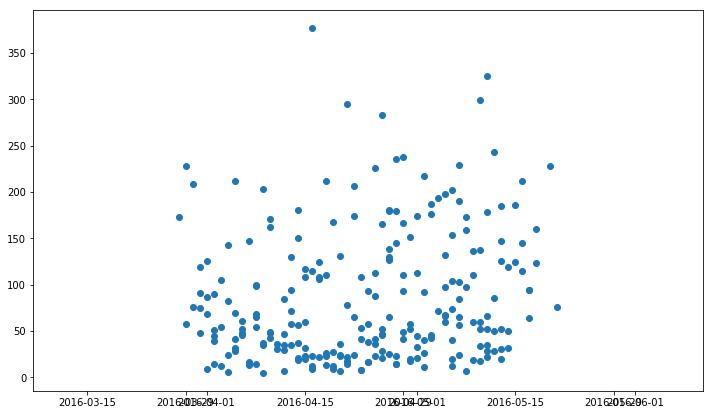

In [229]:
fig = plt.figure(figsize=(12, 7))
plt.scatter(first_week['day'],first_week['ride_duration'])

In [230]:
first_week_daily = pd.DataFrame(big_rides_info[big_rides_info['day'] <= big_rides_info['first_week_milestone']].groupby(['driver_id','day']).ride_duration.sum()).reset_index()
first_week_daily['ride_duration'] = first_week_daily['ride_duration']/60

In [231]:
sub = daily.reset_index().groupby('driver_id').apply(lambda x: x[1:]).drop('driver_id',axis = 1).reset_index().drop('level_1', axis = 1)

In [232]:
change = daily.reset_index().groupby('driver_id').apply(lambda x:(x['ride_duration'][1:].reset_index() - x['ride_duration'][:-1].reset_index())/x['ride_duration'][:-1].reset_index()).reset_index()['ride_duration']

In [235]:
change = pd.merge(sub, change.rename('percent_change'), left_index = True, right_index = True)[['driver_id','day','ride_duration','percent_change']]

In [248]:
change = pd.merge(change, big_drivers_info.driver_onboard_date), left_on = 'driver_id', right_index = True, how = 'left')

In [264]:
change.set_index('driver_id')['driver_onboard_date'] = big_drivers_info.driver_onboard_date

In [276]:
change = pd.merge(change,pd.DataFrame(big_drivers_info.driver_onboard_date), left_on = 'driver_id', right_index = True, how = 'left').drop('driver_onboard_date_x',axis = 1)

In [280]:
change['Number of Days Onboard'] = (change['day']- change['driver_onboard_date_y'].apply(lambda x:x.date())).apply(lambda x: x.days)+1

In [281]:
change

,driver_id,day,ride_duration,percent_change,Number of Days Onboard,driver_onboard_date_y
0,002be0ffdc997bd5c50703158b7c2491,2016-03-31,0.025384,0.591582,3,2016-03-29
1,002be0ffdc997bd5c50703158b7c2491,2016-04-01,0.023940,-0.056903,4,2016-03-29
2,002be0ffdc997bd5c50703158b7c2491,2016-04-02,0.010866,-0.546123,5,2016-03-29
3,002be0ffdc997bd5c50703158b7c2491,2016-04-05,0.019273,0.773754,8,2016-03-29
4,002be0ffdc997bd5c50703158b7c2491,2016-04-07,0.009556,-0.504204,10,2016-03-29
5,002be0ffdc997bd5c50703158b7c2491,2016-04-09,0.002120,-0.778101,12,2016-03-29
6,002be0ffdc997bd5c50703158b7c2491,2016-04-10,0.002106,-0.006550,13,2016-03-29
7,002be0ffdc997bd5c50703158b7c2491,2016-04-11,0.012731,5.043956,14,2016-03-29
8,002be0ffdc997bd5c50703158b7c2491,2016-04-12,0.037329,1.932000,15,2016-03-29
9,002be0ffdc997bd5c50703158b7c2491,2016-04-13,0.019977,-0.464839,16,2016-03-29


In [292]:
change.groupby('driver_id').percent_change.mean().to_csv('average_churn_rate.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


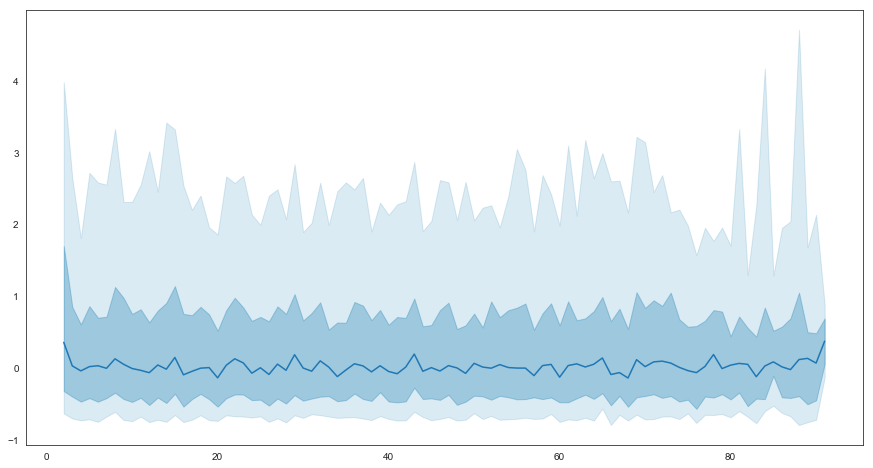

In [289]:
fig = plt.figure(figsize = (15,8))

sns.set_style('white')
ax = plt.gca()
data = change.groupby('Number of Days Onboard').median()
ax.plot(data.index, data.percent_change)
q25 = change.groupby('Number of Days Onboard').percent_change.quantile(0.25)
q75 = change.groupby('Number of Days Onboard').percent_change.quantile(0.75)
q10 = change.groupby('Number of Days Onboard').percent_change.quantile(0.10)
q90 = change.groupby('Number of Days Onboard').percent_change.quantile(0.90)
# plot shadow for 25-75th percentile 
col = sns.xkcd_rgb['nice blue']
ax.fill_between( data.index, q25, q75, alpha=0.3, color=col )
ax.fill_between( data.index, q10, q90, alpha=0.15, color=col )

In [301]:
np.log(change.groupby('driver_id').percent_change.mean().fillna(0))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


driver_id
002be0ffdc997bd5c50703158b7c2491    0.375787
007f0389f9c7b03ef97098422f902e62   -0.120641
011e5c5dfc5c2c92501b8b24d47509bc   -0.773214
0152a2f305e71d26cc964f8d4411add9   -0.501057
01674381af7edd264113d4e6ed55ecda   -1.739513
0213f8b59219e32142711992ca4ec01f   -0.694412
021e5cd15ef0bb3ec20a12af99e142b3    0.521154
0258e250ca195cc6258cbdc75aecd853    0.157657
028b5a4dcd7f4924ebfabcf2e814c014   -0.212429
02d6a6b8a6da15fc219a9570f7ebbe78    1.302819
02e440f6c209206375833cef02e0cbae    1.189482
036f3d94e7c65e4e3574822d31c72656   -0.933753
039c5afbca8e03e4c18d9c8ea94140ac   -0.529902
039da9c077e17af98ca8530e4d7975f1   -1.118310
03f2b5c74cb89f39e58711699e76bf39   -0.578687
03f5278eb43475aa6790f5be32463755   -0.933658
0430df9a3eb327122c57ee3a64765000   -1.394755
04c4ffa5a385eab86fa7e422263d2999   -2.344863
04d686ef2fba281e395992a28f14fdd3   -2.346865
052bba06c5fc0bdea4bc2f9cb92b37c7   -1.113808
059ed570673c2d15ca11dd6b3a25513b   -0.814067
05addf442c147875efa5cf53453ad47b    0.151105


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


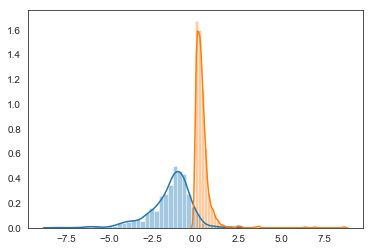

In [357]:
#sns.boxplot(np.log(change.groupby('driver_id').percent_change.mean()))
sns.distplot(np.log(churn_rate).dropna())
sns.distplot(churn_rate.dropna())


In [374]:
big_drivers_info['churned'] = 'Rentention'
big_drivers_info['churned'][churn_rate[np.log(churn_rate) < np.log(churn_rate).mean()-np.log(churn_rate).std()].index] = 'Churned'
big_drivers_info['churn rate'] = churn_rate

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [384]:
temp.columns

Index(['prime time rides percentage', 'average daily active time(hrs/day)',
       'gross fare(over all rides)', 'average daily fare',
       'average fare per ride', 'average monthly fare', 'total rides',
       'number of abnormal rides', 'completion rate', 'active days',
       'average arriving time(minutes)', 'last_ride', 'driver_onboard_date',
       'total days with Lyft', 'Retention Rate', 'Lifetime Value', 'Lifetime',
       'Work_Period', 'Value', 'Average Speed', 'Average Single Ride Duration',
       'Average Single Ride Distance', 'churned', 'churn rate'],
      dtype='object')

In [402]:
big_drivers_info['total distance'] = big_rides_info.reset_index().groupby('driver_id').ride_distance.sum()

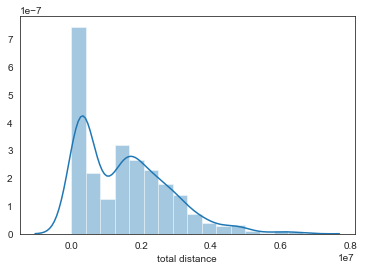

In [404]:
sns.distplot(big_drivers_info['total distance'])

In [417]:
big_drivers_info[big_drivers_info['total distance']>= big_drivers_info['total distance'].std()+ big_drivers_info['total distance'].mean()]

,prime time rides percentage,average daily active time(hrs/day),gross fare(over all rides),average daily fare,average fare per ride,average monthly fare,total rides,number of abnormal rides,completion rate,active days,...,Lifetime,Work_Period,Value,Average Speed,Average Single Ride Duration,Average Single Ride Distance,churned,churn rate,total distance,tired
driver_id,,,,,,,,,,,,,,,,,,,,,
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,5457.997548,136.449939,14.554660,1819.332516,375,0,1.000000,40,...,2.369478,Day,High,7.498338,953.181333,8329.717333,Rentention,0.119055,3123644,Energetic
028b5a4dcd7f4924ebfabcf2e814c014,0.275482,2.496930,5262.509482,134.936141,14.497271,2631.254741,363,0,1.000000,39,...,2.857143,Day,High,7.409827,965.754821,8133.942149,Rentention,0.606463,2952621,Energetic
08a1491d6a804e0af969f08252ddbbd8,0.427320,2.319236,8320.330337,130.005162,14.571507,2773.443446,571,0,1.000000,64,...,4.736842,Day,High,6.163158,935.817863,6684.922942,Rentention,0.373845,3817091,Energetic
08b2b063cce8d02495c4b880293f153c,0.429119,2.481989,7800.835711,139.300638,14.944130,2600.278570,522,0,1.000000,56,...,3.617021,Day,High,6.451843,958.561303,7286.285441,Rentention,0.327908,3803441,Energetic
0f346940b7c9dc770d408b1063ed2f81,0.457265,2.226053,7679.325398,134.725007,16.408815,2559.775133,468,0,1.000000,57,...,3.032787,Day,High,6.335635,976.038462,7296.974359,Rentention,0.600325,3414984,Energetic
100979abe35f7761f333bb7e63649767,0.240426,2.253382,6124.601679,120.090229,13.031067,2041.533893,470,0,1.000000,51,...,2.241379,Day,High,6.537621,880.257447,6556.787234,Rentention,0.345600,3081690,Energetic
113d6a61dd3bd21e5bc39bc19197f0f4,0.188605,1.704631,6039.487976,94.367000,11.865399,2013.162659,509,0,1.000000,64,...,3.040293,Day,High,7.103868,771.605108,6396.428291,Rentention,0.452706,3255782,Energetic
11506b81721ca68ef019764de3d8edbd,0.364760,3.020441,9187.040360,164.054292,14.199444,3062.346787,647,0,1.000000,56,...,3.975904,Day,High,6.647899,941.145286,7181.819165,Rentention,0.525851,4646637,Energetic
12933735316b452a5bc6a933d1a38124,0.468635,1.997545,6761.102240,120.733969,12.474358,2253.700747,542,0,1.000000,56,...,5.081967,Day,High,6.494257,742.998155,5336.896679,Rentention,0.145824,2892598,Energetic


In [425]:
big_drivers_info['tired'] = 'Energetic'
big_drivers_info.loc[big_drivers_info['total distance']>= big_drivers_info['total distance'].std()*2 + big_drivers_info['total distance'].mean(),'tired'] = 'Tired'


In [432]:
big_drivers_info.groupby('churned').describe().T

churned                                        Churned    Rentention
prime time rides percentage        count  1.130000e+02  7.240000e+02
                                   mean   3.099593e-01  3.300766e-01
                                   std    1.248564e-01  1.151003e-01
                                   min    3.703704e-02  0.000000e+00
                                   25%    2.127660e-01  2.569597e-01
                                   50%    3.095238e-01  3.394020e-01
                                   75%    3.888889e-01  4.049516e-01
                                   max    6.333333e-01  7.536232e-01
average daily active time(hrs/day) count  1.130000e+02  7.240000e+02
                                   mean   1.341462e+00  1.548230e+00
                                   std    7.313627e-01  6.627419e-01
                                   min    2.431944e-01  1.585185e-01
                                   25%    8.517929e-01  1.043289e+00
                                   50%    1.205509e+00  1.516679e+00
                                   75%    1.588444e+00  1.947475e+00
                                   max    3.978254e+00  4.281667e+00
gross fare(over all rides)         count  1.130000e+02  7.240000e+02
                                   mean   8.150981e+02  3.392495e+03
                                   std    1.105042e+03  2.445414e+03
                                   min    3.646584e+01  2.567572e+01
                                   25%    4.003511e+02  7.815171e+02
                                   50%    5.070707e+02  3.368568e+03
                                   75%    6.905506e+02  4.953161e+03
                                   max    6.597525e+03  1.263089e+04
average daily fare                 count  1.130000e+02  7.240000e+02
                                   mean   7.573520e+01  8.988214e+01
                                   std    4.091764e+01  3.732593e+01
                                   min    1.823292e+01  8.558573e+00
                                   25%    4.849709e+01  6.140351e+01
                                   50%    6.507873e+01  8.804087e+01
...                                                ...           ...
Average Single Ride Duration       std    1.444004e+02  1.021012e+02
                                   min    5.377925e+02  5.706667e+02
                                   25%    7.674737e+02  7.925256e+02
                                   50%    8.399677e+02  8.562435e+02
                                   75%    9.450000e+02  9.179626e+02
                                   max    1.558208e+03  1.556242e+03
Average Single Ride Distance       count  1.130000e+02  7.240000e+02
                                   mean   6.851125e+03  7.260683e+03
                                   std    2.333631e+03  2.058702e+03
                                   min    3.561767e+03  3.298333e+03
                                   25%    5.262786e+03  5.914159e+03
                                   50%    6.460964e+03  6.723248e+03
                                   75%    8.077245e+03  8.105589e+03
                                   max    1.799400e+04  2.580192e+04
churn rate                         count  1.130000e+02  7.240000e+02
                                   mean   3.270367e-02  4.546769e-01
                                   std    2.027799e-02  5.962266e-01
                                   min    3.237021e-04 -2.010198e-02
                                   25%    1.579733e-02  1.945049e-01
                                   50%    2.981849e-02  3.285282e-01
                                   75%    5.159426e-02  5.245094e-01
                                   max    6.892922e-02  8.623495e+00
total distance                     count  1.130000e+02  7.240000e+02
                                   mean   4.085412e+05  1.703319e+06
                                   std    5.552490e+05  1.249451e+06
                                   min    2.407200e+04  9.895000e+0

In [477]:
# Permutation Test
results = big_drivers_info[big_drivers_info['Work_Period'] == 'Night'].copy().reset_index()
obs = results.groupby('churned').apply(lambda x: x['total rides'].mean()).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        results[['churned', 'total rides']]
        .assign(churned=results.churned.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('churned')
        .apply(lambda x: x['total rides'].mean())
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)


0.0


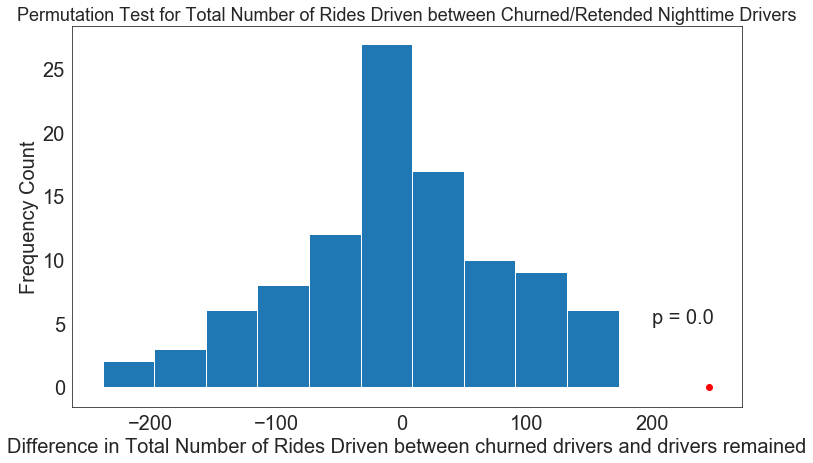

In [480]:
print(pd.Series(obs <= metrs).mean())
fig = plt.figure(figsize=(12, 7))
ax = (pd.Series(metrs)).plot(kind='hist', fontsize = 20)
plt.scatter(obs, 0, c='r');
plt.xlabel('Difference in Total Number of Rides Driven between churned drivers and drivers remained', fontsize = 20)
plt.ylabel('Frequency Count', fontsize = 20)
plt.title('Permutation Test for Total Number of Rides Driven between Churned/Retended Nighttime Drivers',fontsize = 18)
plt.text(200,5, 'p = ' + str(pd.Series(obs <= metrs).mean()), fontsize = 20)
fig.savefig('Perm Test Total Number of rides vs churned Night.jpg',dpi=300)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Prime Time Rides Percentage for Drivers with Different Level of Lifetime Value')

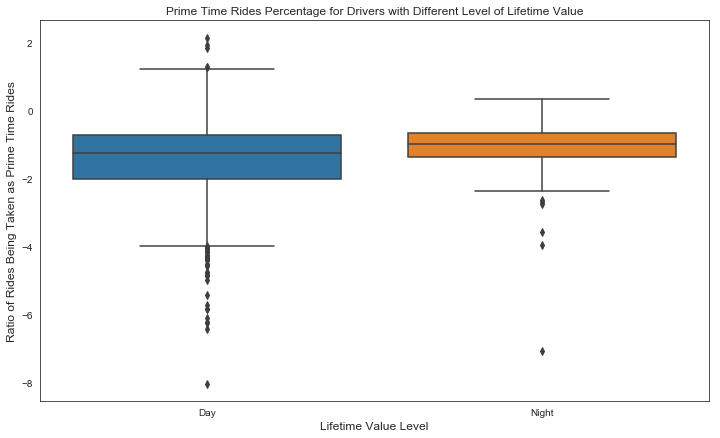

In [482]:
fig = plt.figure(figsize=(12, 7))
temp = big_drivers_info.copy()
temp['churn rate'] = np.log(temp['churn rate'])

sns.boxplot(x = 'Work_Period', y = 'churn rate',  data = temp)
#sns.swarmplot(x = 'Work_Period', y = 'churn rate', data = temp,color=".25")
plt.xlabel('Lifetime Value Level', fontsize = 12)
plt.ylabel('Ratio of Rides Being Taken as Prime Time Rides', fontsize = 12)
plt.title('Prime Time Rides Percentage for Drivers with Different Level of Lifetime Value', fontsize = 12)
#fig.savefig('Boxplot Comparison for Prime Time Rides Percentage.jpg',dpi=300)

In [364]:
churned = churn_rate[np.log(churn_rate) < np.log(churn_rate).mean()-np.log(churn_rate).std()]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


driver_id
011e5c5dfc5c2c92501b8b24d47509bc    0.066727
0430df9a3eb327122c57ee3a64765000    0.023893
04c4ffa5a385eab86fa7e422263d2999    0.015385
04d686ef2fba281e395992a28f14fdd3    0.063054
052bba06c5fc0bdea4bc2f9cb92b37c7    0.053968
06b1ba06e5505f8218ec8686498f990a    0.018001
0938ed763cb3129ae63607aaf69daff5    0.056329
0b10af0ede0648dbe6ae05813c5cbf1b    0.015999
1110d496149d3d8c50276765924df831    0.034798
14183e69946d782c92eb53b3c6eeb86f    0.007990
173a168d2b8830525f59be85a35f0000    0.002207
186d02f3ae489428440a352e3fe503a4    0.030004
1cf95d6dd025d792340b623bcff18260    0.038448
1eb30783865c10a8abc395e1b73bd578    0.020600
258e3bc5c82e3f687b4e999bc598374e    0.043433
276f6a36e30c69076c4cab7970ade946    0.012936
28e4da66781b209cd9a299365a0dcab0    0.025207
2a4afd4ab156dd0a6a0dc48bdf5d8db7    0.066274
2cc500616c927ce30d0bd1e87c699ef5    0.001950
2e5d7b104b570a5cf450f6825880c9dc    0.028349
2e882efad8288189f654defcd3dbcd64    0.057211
2ebb15757eae00c4c491f569ca1a72a4    0.010896


In [351]:
churn_rate[churn_rate < (churn_rate.mean()-churn_rate.std()*2)]

Series([], dtype: float64)

In [356]:
# Define Churn Rate as the product of average percentage change of drivers being active and the active level of drivers
churn_rate =  big_drivers_info['Retention Rate']*change.groupby('driver_id').percent_change.mean()

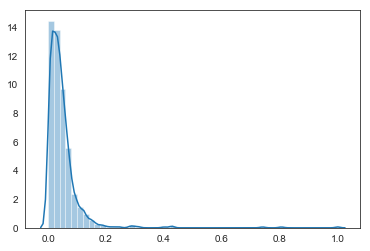

In [327]:
sns.distplot((churn_rate-min(churn_rate))/(max(churn_rate)-min(churn_rate)))

In [257]:
def plot_dist(title, data, condition, UID, ax, col, name = ' '):
    sns.set_style('white')
    data = pd.to_numeric(data, errors='coerce').dropna() 
    # group the data every ten minutes of the day
    tgrp = data.groupby(ten_minutely)
    med = tgrp.median()
    # the datetime.time index doesn't plot properly, so turn back into full datetimes 
    times = med.index.to_series().apply( lambda x: pd.to_datetime( x.isoformat() ) ).values
    # plot the median
    ax.plot(times, med, color=col, label=condition)
    #
    ax = plt.gca()
    q25 = tgrp.quantile(0.25)
    q75 = tgrp.quantile(0.75)
    q10 = tgrp.quantile(0.10)
    q90 = tgrp.quantile(0.90)
    # plot shadow for 25-75th percentile 
    ax.fill_between( times, q25, q75, alpha=0.3, color=col )
    ax.fill_between( times, q10, q90, alpha=0.15, color=col )
    
    # format the ticks for every 4 hours throughout the day
    tFmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(0,24,4)))
    ax.xaxis.set_major_formatter(tFmt)
    ax.set_ylim((30,250)) #reasonable values of blood sugar, make all plots have same y-axis for comparison's sake
    ax.grid(True)
    plt.xlabel('Time of day')
    plt.ylabel('Blood glucose (mg/dL)')
    plt.title('{} {}'.format(title, cal[condition]))
    

,driver_id,day,ride_duration,percent_change,driver_onboard_date,Number of Days Onboard
0,002be0ffdc997bd5c50703158b7c2491,2016-03-31,0.025384,0.591582,2016-03-29,3.0
1,002be0ffdc997bd5c50703158b7c2491,2016-04-01,0.023940,-0.056903,2016-03-29,4.0
2,002be0ffdc997bd5c50703158b7c2491,2016-04-02,0.010866,-0.546123,2016-03-29,5.0
3,002be0ffdc997bd5c50703158b7c2491,2016-04-05,0.019273,0.773754,2016-03-29,8.0
4,002be0ffdc997bd5c50703158b7c2491,2016-04-07,0.009556,-0.504204,2016-03-29,10.0
5,002be0ffdc997bd5c50703158b7c2491,2016-04-09,0.002120,-0.778101,2016-03-29,12.0
6,002be0ffdc997bd5c50703158b7c2491,2016-04-10,0.002106,-0.006550,2016-03-29,13.0
7,002be0ffdc997bd5c50703158b7c2491,2016-04-11,0.012731,5.043956,2016-03-29,14.0
8,002be0ffdc997bd5c50703158b7c2491,2016-04-12,0.037329,1.932000,2016-03-29,15.0
9,002be0ffdc997bd5c50703158b7c2491,2016-04-13,0.019977,-0.464839,2016-03-29,16.0


prime time rides percentage                      0.369697
average daily active time(hrs/day)                1.96375
gross fare(over all rides)                        4693.58
average daily fare                                123.515
average fare per ride                              14.223
average monthly fare                              2346.79
total rides                                           330
number of abnormal rides                                0
completion rate                                         1
active days                                            38
average arriving time(minutes)                    4.94707
last_ride                             2016-06-26 00:00:00
driver_onboard_date                   2016-05-04 00:00:00
total days with Lyft                                   54
Retention Rate                                   0.703704
Lifetime Value                                     8334.4
Lifetime                                          2.52336
Work_Period   